In [1]:
from pyscf import gto, scf, cc
import numpy as np
from jax import numpy as jnp
from jax import vmap, jvp, jit
import jax
from functools import partial

a = 2 # 2aB
nH = 4
atoms = ""
for i in range(nH):
    atoms += f"H {i*a:.5f} 0.00000 0.00000 \n"

mol = gto.M(atom=atoms, basis="sto6g", unit='B', spin=0, verbose=4)
mol.build()

mf = scf.UHF(mol)
mf.kernel()

mo = mf.stability()[0]
dm = mf.make_rdm1(mo,mf.mo_occ)
mf.kernel(dm0=dm)
mo = mf.stability()[0]
dm = mf.make_rdm1(mo,mf.mo_occ)
mf.kernel(dm0=dm)


nfrozen = 0
mycc = cc.CCSD(mf,frozen=nfrozen)
mycc.kernel()[0]

et = mycc.ccsd_t()

System: uname_result(system='Linux', node='yichi-thinkpad', release='4.4.0-26100-Microsoft', version='#7309-Microsoft Fri Jan 01 08:00:00 PST 2016', machine='x86_64')  Threads 12
Python 3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:16:10) [GCC 13.3.0]
numpy 1.24.3  scipy 1.14.1  h5py 3.12.1
Date: Sat Jan 31 16:43:18 2026
PySCF version 2.8.0
PySCF path  /home/yichi/research/software/lno_pyscf
GIT HEAD (branch master) ef75f4190e4de208685670651dc6c467f72b6794

[ENV] PYSCF_EXT_PATH /home/yichi/research/software/pyscf
[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 4
[INPUT] num. electrons = 4
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = B
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 H      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.000000000

In [2]:
options = {'n_eql': 3,
           'n_prop_steps': 50,
            'n_ene_blocks': 1,
            'n_sr_blocks': 5,
            'n_blocks': 10,
            'n_walkers': 50,
            'seed': 2,
            'walker_type': 'uhf',
            'trial': 'uhf',
            'free_projection': True,
            'dt':0.01,
            'use_gpu': False
            }

from ad_afqmc import pyscf_interface
pyscf_interface.prep_afqmc(mycc,options,chol_cut=1e-5)

option_file='options.bin'
import pickle
with open(option_file, 'wb') as f:
    pickle.dump(options, f)

#
# Preparing AFQMC calculation
# If you import pyscf cc modules and use MPI for AFQMC in the same script, finalize MPI before calling the AFQMC driver.
# Calculating Cholesky integrals


# Finished calculating Cholesky integrals
#
# Size of the correlation space:
# Number of electrons: (2, 2)
# Number of basis functions: 4
# Number of Cholesky vectors: 9
#


In [3]:
import numpy as np
from jax import random
from jax import numpy as jnp
from functools import partial
from ad_afqmc import config
from ad_afqmc import mpi_jax

# Hostname: yichi-thinkpad
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64


In [4]:
config.setup_jax()
MPI = config.setup_comm()
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

print = partial(print, flush=True)

ham_data, ham, prop, trial, wave_data, sampler, observable, options, _ = (mpi_jax._prep_afqmc())

# Hostname: yichi-thinkpad
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64
# Number of MPI ranks: 1
#
# norb: 4
# nelec: (2, 2)
#
# n_eql: 3
# n_prop_steps: 50
# n_ene_blocks: 1
# n_sr_blocks: 5
# n_blocks: 10
# n_walkers: 50
# seed: 2
# walker_type: uhf
# trial: uhf
# free_projection: True
# dt: 0.01
# use_gpu: False
# n_exp_terms: 6
# orbital_rotation: True
# do_sr: True
# symmetry: False
# save_walkers: False
# ene0: 0.0
# n_batch: 1
# LNO: False
# orbE: 0
# maxError: 0.001
#


In [50]:
from ad_afqmc import linalg_utils
from jax import lax

def uwalker_norm(
    walker_up: jax.Array,
    walker_dn: jax.Array,
) -> float:
    norm = jnp.linalg.det(walker_up.T.conj() @ walker_up
        ) * jnp.linalg.det(walker_dn.T.conj() @ walker_dn)
    return jnp.real(norm)

@partial(jit, static_argnums=(0))
def propagate_free(prop, ham_data, prop_data, fields):
    shift_term = jnp.einsum("wg,sg->sw", fields, ham_data["mf_shifts_fp"])
    constants = jnp.einsum(
        "sw,s->sw",
        jnp.exp(-jnp.sqrt(prop.dt) * shift_term),
        jnp.exp(prop.dt * ham_data["h0_prop_fp"]),
    )
    prop_data["walkers"] = prop._apply_trotprop(
        ham_data, prop_data["walkers"], fields
    )
    prop_data["walkers"] = prop._multiply_constant(prop_data["walkers"], constants)
    # prop_data["walkers"], norms = linalg_utils.qr_vmap_uhf(prop_data["walkers"])
    # prop_data["weights"] *= jnp.real(norms[0] * norms[1])
    # prop_data = prop.stochastic_reconfiguration_local(prop_data)
    return prop_data

@partial(jit, static_argnums=(3))
def fp_step(prop_data, fields, ham_data, prop):
    """A Free propagation step of nwalkers"""
    prop_data = propagate_free(prop, ham_data, prop_data, fields)
    # prop_data = prop.stochastic_reconfiguration_local(prop_data)
    return prop_data, fields

@partial(jit, static_argnums=(2, 3, 5))
def fp_block(prop_data, ham_data, prop, trial, wave_data, sampler):
    """free propagation for a block of (n_prop_steps, n_walkers)."""
    prop_data["key"], subkey = random.split(prop_data["key"])
    fields = random.normal(
        subkey,
        shape=(
            sampler.n_prop_steps,
            prop.n_walkers,
            ham_data["chol"].shape[0],
        ),
    )
    _step_scan_wrapper = lambda x, y: fp_step(x, y, ham_data, prop)
    prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)

    prop_data["overlaps"] = (trial.calc_overlap(prop_data["walkers"], wave_data))
    prop_data["weights"] = prop_data["weights"] / jnp.sum(prop_data["weights"])
    block_weight = jnp.sum(prop_data["overlaps"] * prop_data["weights"])
    energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
    energy_samples = jnp.where(
        jnp.abs(energy_samples - prop_data["e_estimate"]
                ) > jnp.sqrt(2./prop.dt), prop_data["e_estimate"],
                energy_samples)
    block_energy = jnp.sum(
        energy_samples * prop_data["overlaps"] * prop_data["weights"]
        ) / jnp.sum(prop_data["overlaps"] * prop_data["weights"])
    block_weight = jnp.sum(prop_data["overlaps"])
    return prop_data, (block_energy, block_weight)


@jit
def stochastic_reconfiguration_uhf(walkers, weights, zeta):
    nwalkers = walkers[0].shape[0]
    cumulative_weights = jnp.cumsum(jnp.abs(weights))
    total_weight = cumulative_weights[-1]
    average_weight = total_weight / nwalkers
    weights = jnp.ones(nwalkers) * average_weight
    z = total_weight * (jnp.arange(nwalkers) + zeta) / nwalkers
    indices = vmap(jnp.searchsorted, in_axes=(None, 0))(cumulative_weights, z)
    walkers[0] = walkers[0][indices]
    walkers[1] = walkers[1][indices]
    return walkers, weights

@partial(jit, static_argnums=(2, 3, 5))
def fp_block_sr(prop_data, ham_data, prop, trial, wave_data, sampler):
    """free propagation for a block of (n_prop_steps, n_walkers)."""
    prop_data["key"], subkey = random.split(prop_data["key"])
    fields = random.normal(
        subkey,
        shape=(
            sampler.n_prop_steps,
            prop.n_walkers,
            ham_data["chol"].shape[0],
        ),
    )
    _step_scan_wrapper = lambda x, y: fp_step(x, y, ham_data, prop)
    prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)

    prop_data["walkers"], norms = linalg_utils.qr_vmap_uhf(prop_data["walkers"])
    prop_data["weights"] *= jnp.abs(norms)
    prop_data["weights"] = prop_data["weights"] / jnp.sum(prop_data["weights"])
    prop_data = prop.stochastic_reconfiguration_local(prop_data)

    prop_data["overlaps"] = (trial.calc_overlap(prop_data["walkers"], wave_data))
    energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
    energy_samples = jnp.where(
        jnp.abs(energy_samples - prop_data["e_estimate"]
                ) > jnp.sqrt(2./prop.dt), prop_data["e_estimate"],
                energy_samples)
    
    block_weight = jnp.sum(prop_data["overlaps"] * prop_data["weights"])
    
    block_energy = jnp.sum(
        energy_samples * prop_data["overlaps"] * prop_data["weights"]
        ) / jnp.sum(prop_data["overlaps"] * prop_data["weights"])

    # prop_data = prop.stochastic_reconfiguration_local(prop_data)
    # prop_data["key"], subkey = random.split(prop_data["key"])
    # zeta = random.uniform(subkey)
    # prop_data["walkers"], prop_data["weights"] \
    #     = c_stochastic_reconfiguration_uhf(prop_data["walkers"], prop_data["weights"], zeta)

    return prop_data, (block_energy, block_weight)


@partial(jit, static_argnums=(2, 3, 5))
def fp_block_abs(prop_data, ham_data, prop, trial, wave_data, sampler):
    """free propagation for a block of (n_prop_steps, n_walkers)."""
    prop_data["key"], subkey = random.split(prop_data["key"])
    fields = random.normal(
        subkey,
        shape=(
            sampler.n_prop_steps,
            prop.n_walkers,
            ham_data["chol"].shape[0],
        ),
    )
    _step_scan_wrapper = lambda x, y: fp_step(x, y, ham_data, prop)
    prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)

    prop_data["overlaps"] = (trial.calc_overlap(prop_data["walkers"], wave_data))
    prop_data["weights"] = prop_data["weights"] / jnp.sum(prop_data["weights"])

    energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)

    block_energy = jnp.sum(
        energy_samples * jnp.abs(prop_data["overlaps"]) * prop_data["weights"]
        ) / jnp.sum(jnp.abs(prop_data["overlaps"]) * prop_data["weights"])
    
    block_weight = jnp.sum(jnp.abs(prop_data["overlaps"]) * prop_data["weights"])

    prop_data["key"], subkey = random.split(prop_data["key"])
    zeta = random.uniform(subkey)
    prop_data["walkers"], prop_data["weights"] \
        = stochastic_reconfiguration_uhf(prop_data["walkers"], prop_data["weights"], zeta)
    # prop_data = prop.stochastic_reconfiguration_local(prop_data)
    return prop_data, (block_energy, block_weight)

In [51]:
seed = options["seed"]
init_walkers = None
trial_rdm1 = trial.get_rdm1(wave_data)
if "rdm1" not in wave_data:
    wave_data["rdm1"] = trial_rdm1
ham_data = ham.build_measurement_intermediates(ham_data, trial, wave_data)
ham_data = ham.build_propagation_intermediates(ham_data, prop, trial, wave_data)

def init_prop(prop, trial, wave_data, ham_data, seed, init_walkers=None):
    prop_data = prop.init_prop_data(trial, wave_data, ham_data, init_walkers)
    # if jnp.abs(jnp.sum(prop_data["overlaps"])) < 1.0e-6:
    #     raise ValueError(
    #         "Initial overlaps are zero. Pass walkers with non-zero overlap."
    #     )
    # prop_data["weights"] = jnp.ones(prop.n_walkers,dtype=jnp.complex128)
    prop_data["weights"] = jnp.ones(prop.n_walkers)
    prop_data["key"] = random.PRNGKey(seed)

    prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
    prop_data["n_killed_walkers"] = 0
    return prop_data

prop_data = init_prop(prop, trial, wave_data, ham_data, seed)
print(prop_data["e_estimate"])

-2.0893454776901197


In [52]:
nstep = 100
fp_e = np.zeros(nstep+1,dtype=np.complex128)
fp_w = np.zeros(nstep+1,dtype=np.complex128)
fp_e[0] = prop_data["e_estimate"]
fp_w[0] = sum(prop_data["weights"])
for n in range(nstep):
    prop_data, (blk_e, blk_w) = \
        fp_block(prop_data, ham_data, prop, trial, wave_data, sampler)
    fp_e[n+1] = blk_e
    fp_w[n+1] = blk_w
    print(n+1, blk_e, blk_w)

1 (-2.1161451404988476-0.0003373355488896215j) (-141.76024765224477+0.02021187944010977j)
2 (-2.132832201481359-0.0024305927383715207j) (-410.37811386375336-0.018239474172340397j)
3 (-2.138749330928198-0.00428336311405639j) (-1199.6243720061852+0.056265775021096864j)
4 (-2.14274215081928-0.0018107805825587078j) (-3631.3025494246876-0.4418030420386323j)
5 (-2.1548892398245565-0.002332229007644653j) (-10266.666145480971-55.87159927805013j)
6 (-2.1568790313175907-0.0031596402600200016j) (-29878.324033512137+313.3923884189597j)
7 (-2.1545968504519175-0.000630880911374647j) (-88760.51397259405-534.8166408283392j)
8 (-2.171773653521882+0.004723987879868043j) (-249245.8727948011-2523.284518953425j)
9 (-2.1715779624750624+0.0016415421319979269j) (-692241.9512133771-8391.393900141837j)
10 (-2.1588160571140054-0.001848840244289831j) (-2106602.3936436004-32284.70864706618j)
11 (-2.1622404126098833-0.007478857160028713j) (-6170885.54412549+138.33034737938578j)
12 (-2.1566420028473146-0.00598084793

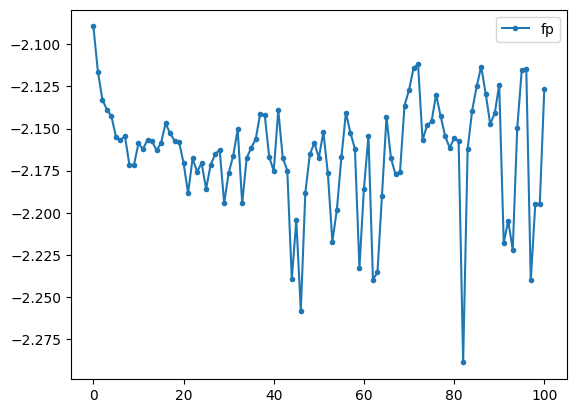

In [53]:
from matplotlib import pyplot as plt

plt.plot(fp_e.real,'.-',label='fp',color='C0')

plt.legend()
plt.show()

In [54]:
prop_data = init_prop(prop, trial, wave_data, ham_data, seed)
print(prop_data["weights"])
print(prop_data["e_estimate"])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
-2.0893454776901197


In [55]:
nstep = 100
fp_sr_e = np.zeros(nstep+1,dtype=np.complex128)
fp_sr_w = np.zeros(nstep+1,dtype=np.complex128)
fp_sr_e[0] = prop_data["e_estimate"]
fp_sr_w[0] = sum(prop_data["weights"])
for n in range(nstep):
    prop_data, (blk_e, blk_w) = \
        fp_block_sr(prop_data, ham_data, prop, trial, wave_data, sampler)
    fp_sr_e[n+1] = blk_e
    fp_sr_w[n+1] = blk_w
    print(n+1, blk_e, blk_w)

1 (-2.104979231271788+3.548419550140358e-05j) (-0.8939790934043814+0.0006283974887091688j)
2 (-2.1479574107295205+0.0032468336202034656j) (-0.7376054570806949-0.0049619117629308394j)
3 (-2.1285642997694474+0.0032747036014165315j) (-0.8053672782672803-0.008871629730001948j)
4 (-2.113662612275927-0.0019085617686105303j) (-0.8594722681833025-0.015640050779630807j)
5 (-2.114055978520619-0.0012804866730417909j) (-0.8443274098596658-0.01986539052516765j)
6 (-2.110962663430666+0.0007553822065528098j) (-0.8630822377594436-0.016307571035090077j)
7 (-2.130285128662565+0.0021824137068049546j) (-0.7610771729839623-0.005473370776343864j)
8 (-2.1777963714006656+0.010731145679534275j) (-0.6276284478382793+0.006036890670565059j)
9 (-2.329142942361329+0.042827754959846j) (-0.39446064564958805-0.02249606069394841j)
10 (-2.4578071278309164+0.06547433556552809j) (-0.287375811083085-0.021620955524616344j)
11 (-2.604751788530816+0.08633099184612748j) (-0.2123717514524437-0.0060227708506914186j)
12 (-2.58278

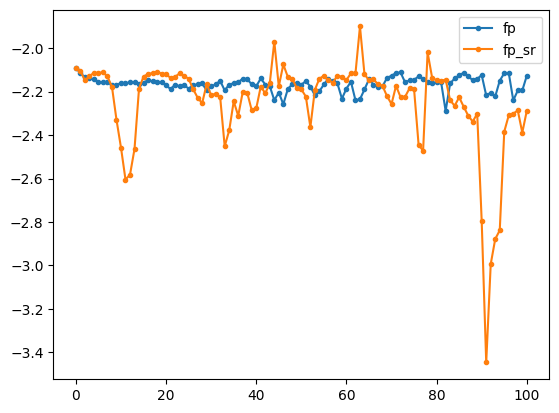

In [56]:
plt.plot(fp_e.real,'.-',label='fp',color='C0')
plt.plot(fp_sr_e.real,'.-',label='fp_sr',color='C1')
plt.legend()
plt.show()

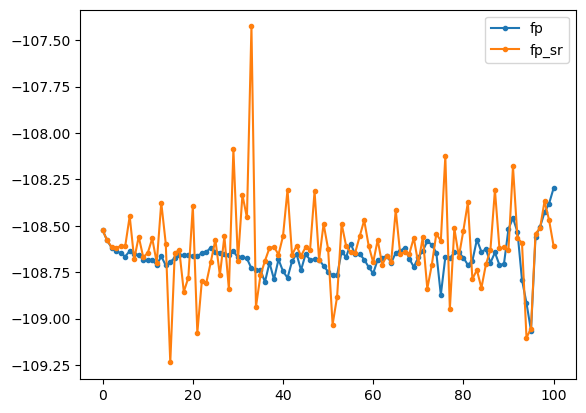

In [157]:
plt.plot(fp_e.real,'.-',label='fp',color='C0')
plt.plot(fp_sr_e.real,'.-',label='fp_sr',color='C1')
plt.legend()
plt.show()

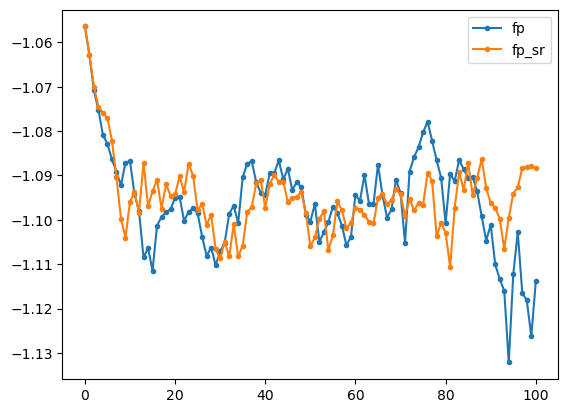

In [146]:
plt.plot(fp_e.real,'.-',label='fp',color='C0')
plt.plot(fp_sr_e.real,'.-',label='fp_sr',color='C1')
plt.legend()
plt.show()

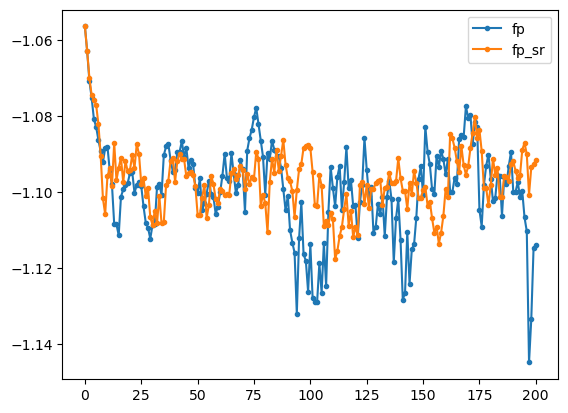

In [46]:
plt.plot(fp_e.real,'.-',label='fp',color='C0')
plt.plot(fp_sr_e.real,'.-',label='fp_sr',color='C1')
plt.legend()
plt.show()

In [115]:
prop_data = init_prop(prop, trial, wave_data, ham_data, seed)
print(prop_data["weights"])
print(prop_data["e_estimate"])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
-108.52346313844822


In [116]:
nstep = 100
fp_abs_e = np.zeros(nstep+1,dtype=np.complex128)
fp_abs_w = np.zeros(nstep+1,dtype=np.complex128)
fp_abs_e[0] = prop_data["e_estimate"]
fp_abs_w[0] = sum(prop_data["weights"])
for n in range(nstep):
    prop_data, (blk_e, blk_w) = \
        fp_block_abs(prop_data, ham_data, prop, trial, wave_data, sampler)
    fp_abs_e[n+1] = blk_e
    fp_abs_w[n+1] = blk_w
    print(n+1, blk_e, blk_w)

1 (-108.55612139611625+0.004015828477594734j) 0.8673800360293547
2 (-108.50832122157824+0.03940563174983206j) 0.9355515192047226
3 (-108.6322148184593-0.0029555317663996243j) 0.6078581964617031
4 (-108.5821274786314-0.03043555182860763j) 0.6699121409536732
5 (-108.346188620654+0.006972540518597901j) 5.06974547685107
6 (-108.79083817610834+0.04612905795295351j) 0.3949140074094235
7 (-108.63463985849117+0.038065693939267835j) 0.6132740168986578
8 (-108.74269069472606+0.0039969390379315j) 0.2969995608291219
9 (-108.64997483913555+0.0069392788691859325j) 0.5542595715218287
10 (-108.69801469573626+0.003623732618849086j) 0.44508936859177006
11 (-108.60941944503612-0.023917343909678913j) 0.58297909956796
12 (-108.57366841681268+0.036932509673389506j) 0.5128436890078778
13 (-108.44664256281452-0.0686019737935416j) 1.1593663652643373
14 (-108.58906459764232+0.08936131332361773j) 0.4486692456812014
15 (-108.65549533378245+0.006669348197795445j) 0.4913149886413442
16 (-108.84530902355733-0.001837

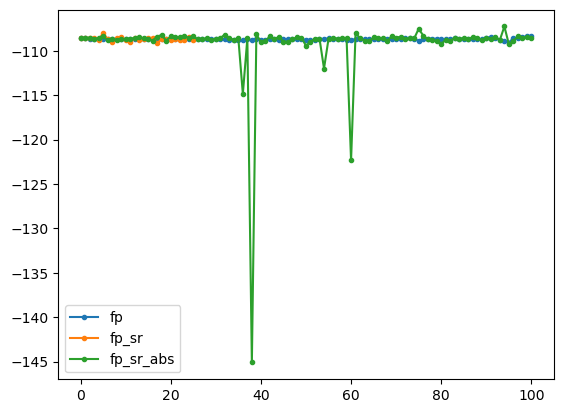

In [117]:
plt.plot(fp_e.real,'.-',label='fp',color='C0')
plt.plot(fp_sr_e.real,'.-',label='fp_sr',color='C1')
plt.plot(fp_abs_e.real,'.-',label='fp_sr_abs',color='C2')
plt.legend()
plt.show()

In [64]:
prop_data = init_prop(prop, trial, wave_data, ham_data, seed)
# print(prop_data["weights"])
# print(prop_data["e_estimate"])
nstep = 200
fp_abs2_e = np.zeros(nstep+1,dtype=np.complex128)
fp_abs2_w = np.zeros(nstep+1,dtype=np.complex128)
fp_abs2_e[0] = prop_data["e_estimate"]
fp_abs2_w[0] = sum(prop_data["weights"])
for n in range(nstep):
    prop_data, (blk_e, blk_w) = \
        fp_block_abs(prop_data, ham_data, prop, trial, wave_data, sampler)
    fp_abs2_e[n+1] = blk_e
    fp_abs2_w[n+1] = blk_w
    print(n+1, blk_e, blk_w)

1 (-1.0628548079724716+0.00022186128123466556j) 96.85316189998582
2 (-1.069942989607628+0.00036079249965208877j) 93.50845512479832
3 (-1.0744637131425452-0.0003360138431473421j) 91.45783654130103
4 (-1.0755908103827283-0.0007344084911181779j) 90.63575936081375
5 (-1.0769675383442803-0.00035562868703795445j) 89.93091574285907
6 (-1.0816797029302856-0.00264176588303383j) 87.70685392750835
7 (-1.0884218692893617-0.004209476356290903j) 84.21568054962061
8 (-1.0998205957418894-0.004877376706393424j) 80.18301357457565
9 (-1.102864646186332-0.0030240325889314603j) 78.48817908393082
10 (-1.093838875404351-0.0026650421165122966j) 82.01753784781623
11 (-1.0929904860902935-0.0021287709965954246j) 82.76807240149783
12 (-1.097188873098694-0.0033103513253432263j) 81.19407382276003
13 (-1.086634469658671-0.002451311239843642j) 85.49548506129342
14 (-1.0960253392355193-0.0005528367473872384j) 81.8645939742683
15 (-1.09246087633156+0.000732083419054176j) 82.79104069962608
16 (-1.0895453404027993+0.0040

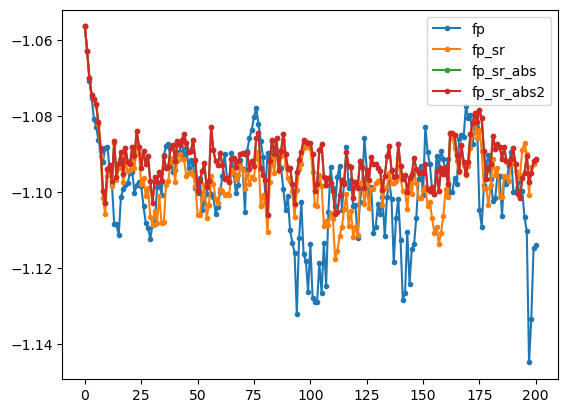

In [65]:
plt.plot(fp_e.real,'.-',label='fp',color='C0')
plt.plot(fp_sr_e.real,'.-',label='fp_sr',color='C1')
plt.plot(fp_abs_e.real,'.-',label='fp_sr_abs',color='C2')
plt.plot(fp_abs2_e.real,'.-',label='fp_sr_abs2',color='C3')
plt.legend()
plt.show()